# Water Management Model Notebook
This notebook demonstrates a machine learning model to predict water usage and control motors based on forecasted needs.

## Importing Required Libraries

In [16]:
import logging
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
# from keras.models import Sequential
# from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from datetime import datetime

## Load Data Function

In [17]:
def load_data(file_path):
    """Load dataset from a CSV file."""
    return pd.read_csv(file_path)

## Create Sequences Function

In [18]:
def create_sequences(data, time_steps=24):
    sequences, targets = [], []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
        targets.append(data[i + time_steps])
    return np.array(sequences), np.array(targets)

## Build CNN Model Function

In [19]:
def build_cnn_model(input_shape):
    """Build a 1D CNN model for water usage prediction."""
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## Train CNN Model Function

In [20]:
def train_cnn_model(X_train, y_train, X_test, y_test):
    cnn_model = build_cnn_model((X_train.shape[1], 1))
    history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
    return cnn_model, history

## Train Other Models Function

In [21]:
# def train_other_models(X_train, y_train):
#     rf_model = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
#     xgb_model = XGBRegressor(n_estimators=100).fit(X_train, y_train)
#     return rf_model, xgb_model

def train_other_models(X_train, y_train):
    # Reshape X_train to 2D for compatibility with the other models
    X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[1])
    
    rf_model = RandomForestRegressor(n_estimators=100).fit(X_train_2d, y_train)
    xgb_model = XGBRegressor(n_estimators=100).fit(X_train_2d, y_train)
    
    return rf_model, xgb_model


## Ensemble Predictions Function

In [22]:
def ensemble_predictions(cnn_model, rf_model, xgb_model, X_test):
    cnn_preds = cnn_model.predict(X_test).flatten()
    rf_preds = rf_model.predict(X_test)
    xgb_preds = xgb_model.predict(X_test)
    return np.column_stack((cnn_preds, rf_preds, xgb_preds))

## Final Model Training Function

In [23]:
def train_final_model(stacked_features, y_test):
    final_model = LinearRegression().fit(stacked_features, y_test)
    return final_model

## Data Visualization Function

In [24]:
# Enhanced plot_data function with markers and gridlines
def plot_data(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data['timestamp'], data['water_usage'], label='Water Usage (%)', color='blue', marker='o', linestyle='-', markersize=4)
    plt.xlabel('Time')
    plt.ylabel('Water Usage (%)')
    plt.title('Water Usage Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Predictions Visualization Function

In [25]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label='Actual Water Usage', color='blue')
    plt.plot(y_pred, label='Predicted Water Usage', color='orange')
    plt.xlabel('Samples')
    plt.ylabel('Water Usage (%)')
    plt.title('Actual vs. Predicted Water Usage')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Model Training Visualization Function

In [26]:
def plot_training_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('CNN Model Training Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Model Evaluation Function

In [27]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f'MSE: {mse}, MAE: {mae}')

## Round-Robin Motor Operation Scheduler

In [28]:
def is_peak_hour():
    return 17 <= datetime.now().hour <= 20
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Round-robin scheduler with logging
def round_robin_scheduler(motors, water_levels, forecasted_needs, threshold=30):
    for motor_id in motors:
        if water_levels[motor_id] < forecasted_needs[motor_id] and not is_peak_hour():
            logging.info(f"Activating motor {motor_id}: Water level ({water_levels[motor_id]}%) below threshold for forecasted need ({forecasted_needs[motor_id]}%)")
            print(f"Activating motor {motor_id}")
        else:
            logging.info(f"Skipping motor {motor_id}: Current water level ({water_levels[motor_id]}%) adequate or peak hour active.")
            print(f"Skipping motor {motor_id}")

# def round_robin_scheduler(motors, water_levels, forecasted_needs, threshold=30):
#     for motor_id in motors:
#         if water_levels[motor_id] < forecasted_needs[motor_id] and not is_peak_hour():
#             print(f"Activating motor {motor_id}")
#         else:
#             print(f"Skipping motor {motor_id}")

## Main Execution

In [29]:
def main():
    data = load_data('dataset.csv')
    
    # Validate data structure
    if 'water_usage' not in data.columns:
        raise ValueError("The dataset must contain a 'water_usage' column.")
    
    sequences, targets = create_sequences(data['water_usage'].values)
    X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Train CNN model
    cnn_model, history = train_cnn_model(X_train, y_train, X_test, y_test)
    rf_model, xgb_model = train_other_models(X_train, y_train)
    stacked_features = ensemble_predictions(cnn_model, rf_model, xgb_model, X_test.reshape(X_test.shape[0], X_test.shape[1]))
    
    final_model = train_final_model(stacked_features, y_test)
    y_pred = final_model.predict(stacked_features)
    
    # Evaluate model performance
    evaluate_model(y_test, y_pred)
    
    # Plot results
    plot_training_loss(history)
    plot_data(data)
    plot_predictions(y_test, y_pred)
    
    # Motor scheduling demonstration
    motors = [1, 2, 3]  # Example motor IDs
    water_levels = {1: 25, 2: 40, 3: 30}  # Example water levels (%)
    forecasted_needs = {1: 50, 2: 45, 3: 60}  # Example forecasted needs (%)
    round_robin_scheduler(motors, water_levels, forecasted_needs)

### Execute the Main Function

c:\Projects\Water-consumption-Analysis\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 239.5873 - val_loss: 11.2002
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 26.0285 - val_loss: 9.1889
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.4920 - val_loss: 9.2160
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24.5456 - val_loss: 12.9609
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.8441 - val_loss: 9.2109
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24.6672 - val_loss: 10.3733
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24.4338 - val_loss: 9.6729
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25.4350 - val_loss: 9.1891
Epoch 9/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.4704 - val_loss: 9.2288
Epoch 10/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.5065 - val_loss: 9.1953
Epoch 11/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.4101 - val_loss: 13.5708
Epoch 12/50
180/180 ━━━━━━━━━━━━━━━━

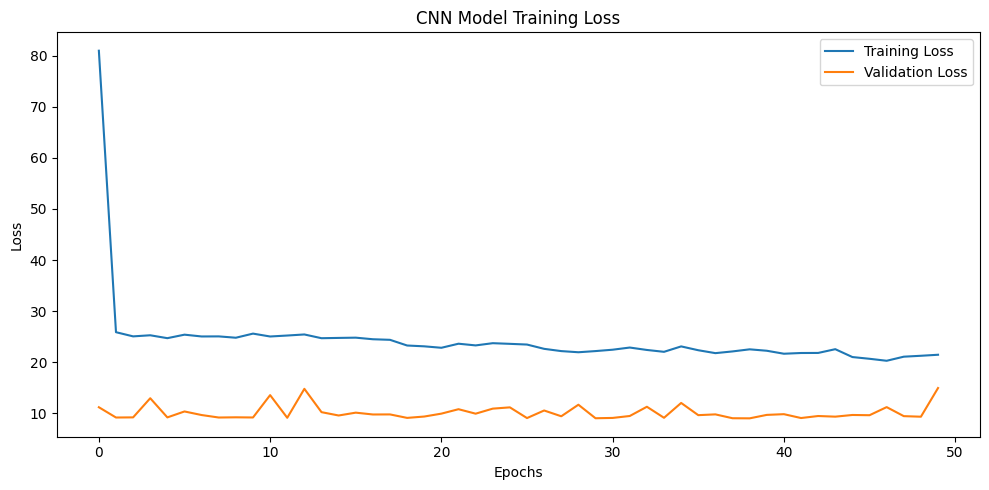

2024-10-27 21:02:55,756 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-27 21:02:55,852 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


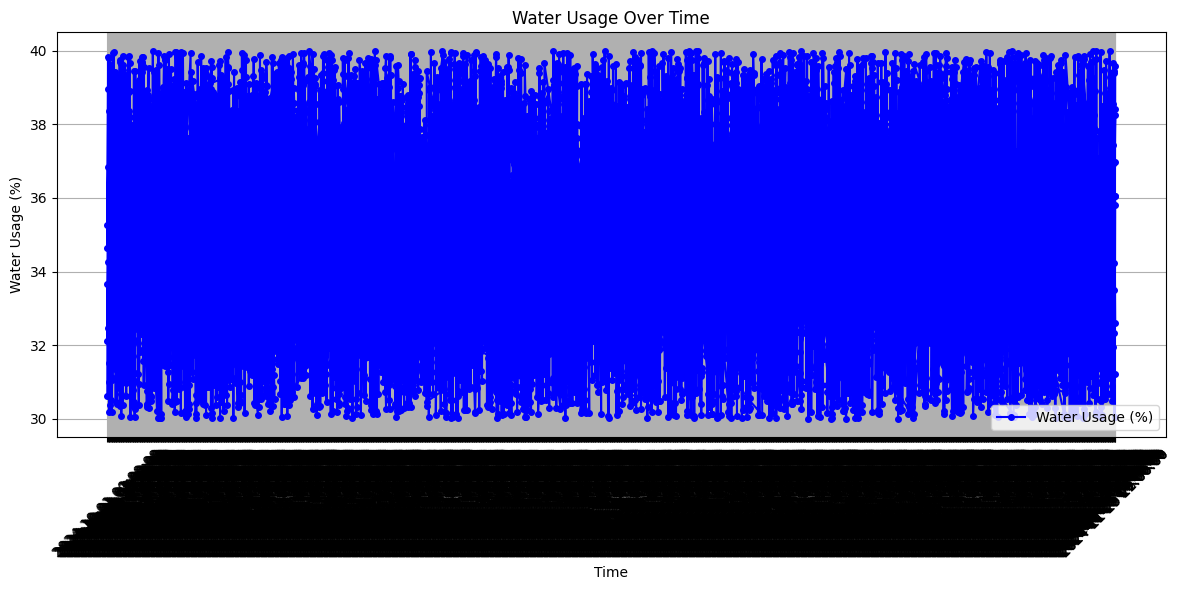

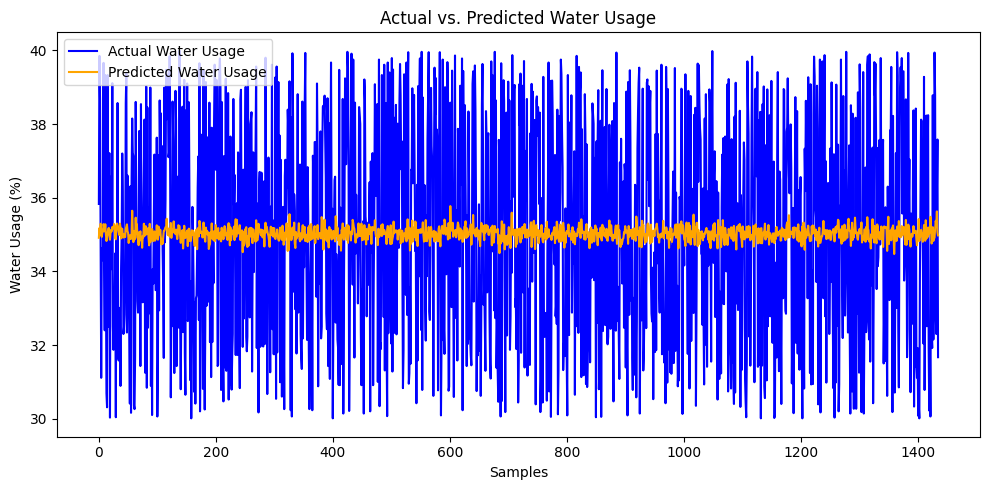

2024-10-27 21:03:01,462 - Activating motor 1: Water level (25%) below threshold for forecasted need (50%)
2024-10-27 21:03:01,463 - Activating motor 2: Water level (40%) below threshold for forecasted need (45%)
2024-10-27 21:03:01,464 - Activating motor 3: Water level (30%) below threshold for forecasted need (60%)


Activating motor 1
Activating motor 2
Activating motor 3


In [30]:
main()